In [1]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 8.1MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp37-none-any.whl size=73269 sha256=e14206857c0d9eea4c6fa46d933a6cff17c078c1c7cd3b3e99cf9c00235fde15
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


In [2]:
import json
import zipfile
import os
api_token = {"username":"bananaiselite","key":"0bb8ab32049c1faeec19ca90afdba245"}

if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")
 
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json


os.chdir('/content')
!kaggle competitions download -c 2021-ml-100-marathon-final-exam
 
!ls /content

 98% 225M/230M [00:02<00:00, 112MB/s]
100% 230M/230M [00:02<00:00, 104MB/s]
2021-ml-100-marathon-final-exam.zip  sample_data


In [3]:
!unzip -q /content/2021-ml-100-marathon-final-exam.zip

先來檢查圖片

In [63]:
import os 
from collections import defaultdict
from PIL import Image, ImageOps
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt

imgs_size = 128
plant_labels = [] 
plant_imgs = [] 
counter = defaultdict(int)


for dirPath, dirNames, fileNames in os.walk("./image_data"):
  if dirNames == []:
    print(dirPath)
    if dirPath.split('/')[-2] =='train':
      for file in fileNames:
        #計算train data數量
        counter[dirPath.split('/')[-1]] +=1
        
        #儲存train data label
        plant_labels.append(dirPath.split('/')[-1])
        #儲存train data 圖片
        im = Image.open(str(dirPath)+'/'+file)
        plant_imgs.append(ImageOps.fit(im, (imgs_size, imgs_size)).convert('RGB'))
  else:
    print(f'Root:{dirPath}')


Root:./image_data
./image_data/test
Root:./image_data/train
./image_data/train/dandelion
./image_data/train/rose
./image_data/train/daisy
./image_data/train/tulip
./image_data/train/sunflower


tulip:633
daisy:500
dandelion:687
sunflower:488
rose:515


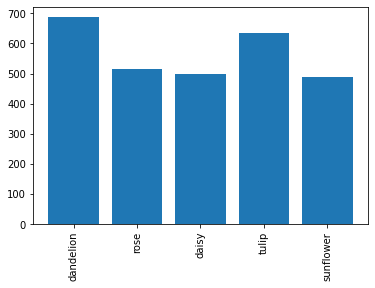

In [64]:
print(f"tulip:{plant_labels.count('tulip')}")
print(f"daisy:{plant_labels.count('daisy')}")
print(f"dandelion:{plant_labels.count('dandelion')}")
print(f"sunflower:{plant_labels.count('sunflower')}")
print(f"rose:{plant_labels.count('rose')}")
plt.bar(counter.keys(), counter.values())
plt.xticks(rotation=90)
plt.show()

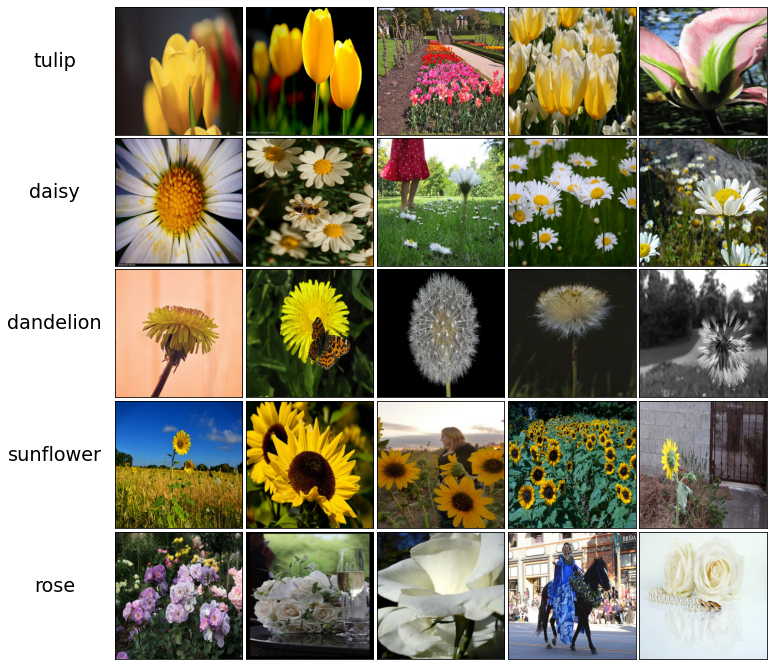

In [65]:
#從各個資料夾中取出5張圖片
train_dir = '/content/image_data/train/'

flower_name = ['tulip', 'daisy', 'dandelion', 'sunflower', 'rose']
flower_pic =[]
for i in range(5):
  counter = 0
  for file in os.listdir(train_dir+flower_name[i]):
    if counter == 5:
      break
    pic = train_dir+flower_name[i]+'/'+file
    flower_pic.append(pic)
    counter += 1

#以格狀圖顯示
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16

fig = plt.figure(1, figsize=(12, 12))
grid = ImageGrid(fig, 111, nrows_ncols=(5,5), axes_pad=0.05) 


for idx, axes in enumerate(grid):
  img = Image.open(flower_pic[idx]).resize((256, 256))
  axes.get_yaxis().set_ticks([]),axes.get_xaxis().set_ticks([])
  if idx % 5 ==0:
    axes.set_ylabel(flower_name[idx//5], rotation=0, size='large', labelpad =60)
  axes.imshow(img)
  
  idx += 1
plt.show()


In [66]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

train_img = np.array([np.array(img) for img in plant_imgs])
#Normalize
train_img = train_img.reshape(train_img.shape[0], imgs_size, imgs_size, 3) / 255
#one-hot encoding
lb = LabelBinarizer().fit(plant_labels) 
labels = lb.transform(plant_labels)

x_train, x_test, y_train, y_test = train_test_split(train_img, labels, test_size=0.15, random_state=100)

In [67]:
import keras
from keras.models import Model,load_model
from keras.layers import Input, Dense, Flatten, Activation, Dropout, Maximum, \
 BatchNormalization, Conv2D, MaxPooling2D
from keras import regularizers
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.advanced_activations import LeakyReLU

In [88]:
def conv_layer(feature_batch, feature_map, kernel_size=(3, 3),strides=(1,1)):
   zp = feature_batch
   conv = Conv2D(filters=feature_map, kernel_size=kernel_size, strides=strides)(zp)
   bn = BatchNormalization(axis=3)(conv)
   act = LeakyReLU(1/10)(bn)
   return act

def dense_set(inp_layer, n, activation, drop_rate=0.):
  dp = Dropout(drop_rate)(inp_layer)
  dns = Dense(n)(dp)
  bn = BatchNormalization(axis=-1)(dns)
  act = Activation(activation=activation)(bn)
  return act

In [98]:
model = keras.Sequential()
input = Input((imgs_size, imgs_size, 3)) # 128, 128
conv1 = conv_layer(input, 64)
conv2 = conv_layer(conv1, 64)
mp1 = MaxPooling2D(pool_size=(5, 5), strides=(2, 2))(conv2)

conv3 = conv_layer(mp1, 128)
conv4 = conv_layer(conv3, 128)
mp2 = MaxPooling2D(pool_size=(5, 5), strides=(2, 2))(conv4)

conv5 = conv_layer(mp2, 256)
conv6 = conv_layer(conv5, 256)
mp3 = MaxPooling2D(pool_size=(5, 5), strides=(2, 2))(conv6)

conv7 = conv_layer(mp3, 512)
conv8 = conv_layer(conv7, 512)
mp4 = MaxPooling2D(pool_size=(5, 5), strides=(2, 2))(conv8)
flat = Flatten()(mp4)

ds1 = dense_set(flat, 128, activation='tanh')
ds2 = dense_set(ds1 , 64, activation='tanh')
ds3 = dense_set(ds2 , 32, activation='tanh')
out = dense_set(ds3, 5, activation='softmax')

model = Model(inputs=input, outputs=out)
opt = Adam(lr= 1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='categorical_crossentropy',
              optimizer=opt, metrics=['acc'])
model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 126, 126, 64)      1792      
_________________________________________________________________
batch_normalization_133 (Bat (None, 126, 126, 64)      256       
_________________________________________________________________
leaky_re_lu_95 (LeakyReLU)   (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 124, 124, 64)      36928     
_________________________________________________________________
batch_normalization_134 (Bat (None, 124, 124, 64)      256       
_________________________________________________________________
leaky_re_lu_96 (LeakyReLU)   (None, 124, 124, 64)      0  

In [99]:
from keras.callbacks import Callback
from sklearn.metrics import f1_score,recall_score, precision_score
from keras.metrics import TrueNegatives, TruePositives, FalseNegatives, FalsePositives

class Mycallback(Callback):
    def __init__(self,val_x, val_y, batch_size = 10):
        super().__init__()
        self.val_x = val_x
        self.val_y = val_y
        self.batch_size = batch_size

    def on_train_begin(self, epoch, logs = {}):
        logs = logs or {}
        record_items = ["val_f1sc", "val_fp", "val_fn", "val_tp", "val_tn"\
                        ,"val_recall", "val_precision"]
        self.params['metrics']= []
        for i in record_items:
            if i not in self.params['metrics']:
                self.params['metrics'].append(i)
        print(self.params)
       
    def on_epoch_end(self, epoch, logs = {}, thres =0.5):

      logs = logs or {}
      y_true = np.argmax(self.val_y, 1)
      y_pred = np.argmax(self.model.predict(self.val_x), 1)

      y_pred_cm = (self.model.predict(self.val_x)[:,:] >= 0.5 )*1


      #TrueNegatives
      tn = TrueNegatives()
      tn.update_state(self.val_y,y_pred_cm)
      logs["val_tn"] = tn.result().numpy()


      #TruePositives
      tp = TruePositives()
      tp.update_state(self.val_y,y_pred_cm)
      logs["val_tp"] = tp.result().numpy()

      #FalseNegatives
      fn = FalseNegatives()
      fn.update_state(self.val_y,y_pred_cm)
      logs["val_fn"] = fn.result().numpy()

      #FalsePositives
      fp = FalsePositives()
      fp.update_state(self.val_y,y_pred_cm)
      logs["val_fp"] = fp.result().numpy()

      #F1 score
      logs["val_f1sc"] = f1_score(y_true = y_true, y_pred = y_pred, average='weighted')

      #recall
      logs['val_recall']=recall_score(y_true, y_pred, average='weighted')

      #precision_score
      logs['val_precision'] = precision_score(y_true, y_pred, average='weighted')



In [100]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

batch_size = 20
epochs = 200

lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.8, min_delta=1e-5, patience=8, verbose=1)

earlystop = EarlyStopping(patience=30) 

modelsave = ModelCheckpoint(filepath='flower_model.h5', save_best_only=True, verbose=1)

callbacks = [lr_reduce, earlystop, modelsave, Mycallback(x_test, y_test, batch_size)]

In [101]:
model_value = model.fit(x_train, y_train, batch_size=batch_size,
                        epochs= epochs, 
                        validation_data=(x_test, y_test),
                        callbacks=callbacks)

{'verbose': 1, 'epochs': 200, 'steps': 120, 'metrics': ['val_f1sc', 'val_fp', 'val_fn', 'val_tp', 'val_tn', 'val_recall', 'val_precision']}
Epoch 1/200
120/120 [==============================] - 12s 85ms/step - loss: 1.3098 - acc: 0.4639 - val_loss: 2.0339 - val_acc: 0.2689

Epoch 00001: val_loss improved from inf to 2.03386, saving model to flower_model.h5
Epoch 2/200
  2/120 [..............................] - ETA: 9s - loss: 1.0191 - acc: 0.6500

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


120/120 [==============================] - 10s 83ms/step - loss: 1.0027 - acc: 0.6467 - val_loss: 2.0902 - val_acc: 0.2807

Epoch 00002: val_loss did not improve from 2.03386
Epoch 3/200
120/120 [==============================] - 10s 85ms/step - loss: 0.9584 - acc: 0.6473 - val_loss: 1.2714 - val_acc: 0.5047

Epoch 00003: val_loss improved from 2.03386 to 1.27137, saving model to flower_model.h5
Epoch 4/200
120/120 [==============================] - 10s 85ms/step - loss: 0.8937 - acc: 0.6555 - val_loss: 1.1016 - val_acc: 0.5778

Epoch 00004: val_loss improved from 1.27137 to 1.10162, saving model to flower_model.h5
Epoch 5/200
120/120 [==============================] - 10s 84ms/step - loss: 0.8669 - acc: 0.6853 - val_loss: 0.9866 - val_acc: 0.6415

Epoch 00005: val_loss improved from 1.10162 to 0.98656, saving model to flower_model.h5
Epoch 6/200
120/120 [==============================] - 10s 83ms/step - loss: 0.8145 - acc: 0.7138 - val_loss: 0.8742 - val_acc: 0.6816

Epoch 00006: val_

In [102]:
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.6,
                          width_shift_range=0.3, height_shift_range=0.3, 
                          shear_range=0.15, horizontal_flip=True, 
                          vertical_flip=True, fill_mode="nearest")

model_value_aug = model.fit_generator(aug.flow(x_train, y_train, batch_size=batch_size),
                                  validation_data=(x_test, y_test), 
                                  steps_per_epoch=len(x_train) // batch_size,
                                  epochs=epochs,
                                  callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


{'verbose': 1, 'epochs': 200, 'steps': 119, 'metrics': ['val_f1sc', 'val_fp', 'val_fn', 'val_tp', 'val_tn', 'val_recall', 'val_precision']}
Epoch 1/200
119/119 [==============================] - 13s 102ms/step - loss: 1.0765 - acc: 0.6309 - val_loss: 0.7957 - val_acc: 0.7099

Epoch 00001: val_loss did not improve from 0.67062
Epoch 2/200
119/119 [==============================] - 12s 101ms/step - loss: 0.8555 - acc: 0.6948 - val_loss: 0.7457 - val_acc: 0.7476

Epoch 00002: val_loss did not improve from 0.67062
Epoch 3/200
119/119 [==============================] - 12s 102ms/step - loss: 0.8029 - acc: 0.7091 - val_loss: 0.7509 - val_acc: 0.7146

Epoch 00003: val_loss did not improve from 0.67062
Epoch 4/200
119/119 [==============================] - 12s 101ms/step - loss: 0.8175 - acc: 0.6995 - val_loss: 0.6357 - val_acc: 0.7854

Epoch 00004: val_loss improved from 0.67062 to 0.63567, saving model to flower_model.h5
Epoch 5/200
119/119 [==============================] - 12s 102ms/step -

In [103]:
# Collect results
train_loss = model_value_aug.history["loss"]
valid_loss = model_value_aug.history["val_loss"]
train_acc = model_value_aug.history["acc"]
valid_acc = model_value_aug.history["val_acc"]

# 在訓練後，將紀錄調出
valid_f1sc = model_value_aug.history['val_f1sc']
valid_tp = model_value_aug.history["val_tp"]
valid_tn = model_value_aug.history["val_tn"]
valid_fp = model_value_aug.history['val_fp']
valid_fn = model_value_aug.history['val_fn']
val_recall = model_value_aug.history['val_recall']
val_precision =model_value_aug.history['val_precision']

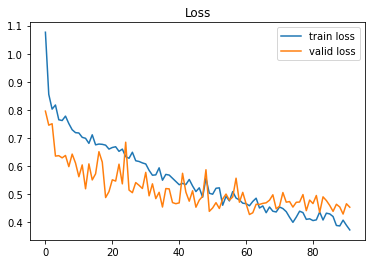

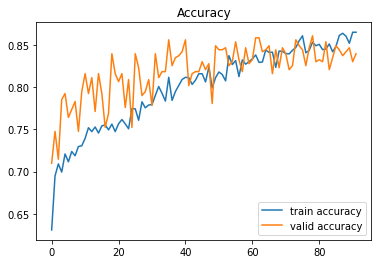

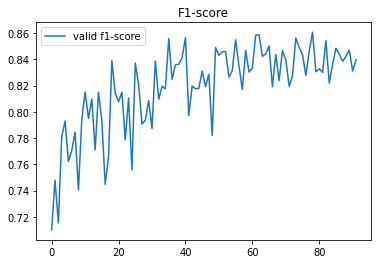

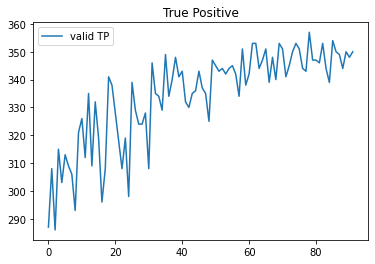

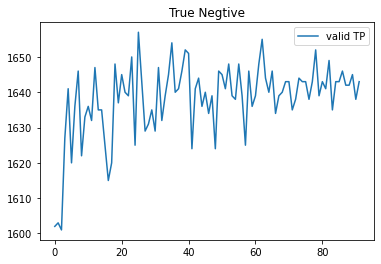

In [104]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(range(len(valid_f1sc)), valid_f1sc, label="valid f1-score")
plt.legend()
plt.title("F1-score")
plt.show()

plt.plot(range(len(valid_f1sc)), valid_tp, label="valid TP")
plt.legend()
plt.title("True Positive" )
plt.show()


plt.plot(range(len(valid_f1sc)), valid_tn, label="valid TP")
plt.legend()
plt.title("True Negtive")
plt.show()

In [105]:
test_label = [] 
test_imgs = [] 
test_dir = '/content/image_data/test/'
for file in os.listdir(test_dir):
  label = file.split('.')[0]
  test_label.append(label)
  im = Image.open(str(test_dir)+file)
  test_imgs.append(ImageOps.fit(im, (imgs_size, imgs_size)).convert('RGB'))

test_imgs = np.array([np.array(im) for im in test_imgs])
test_imgs = test_imgs.reshape(test_imgs.shape[0], imgs_size, imgs_size, 3) / 255

In [106]:
model = load_model('/content/flower_model.h5')
prediction = model.predict(test_imgs)
flower_class =list(prediction.argmax(axis=1))

In [107]:
import pandas as pd
df = pd.DataFrame(data={'id': test_label, 'flower_class':flower_class})
df_sort = df.sort_values(by=['id'])
df_sort.to_csv('submission.csv', index=False)